## Models on Full Features

---

### Objective:

- Given the chosen sampling rate, extraction interval, the selected features, to assess the performance of different models.
- To determine the best model.

#### Findings:

- Sampling Rate: 4000 Hz
- Extraction Interval: 1 s
- Balancing Type: posteriori
- Selected Features:

  | Type                | N° Features |
  | ------------------- | ----------- |
  | MFCC                | 30          |
  | CQT                 | 70          |
  | Chroma              | 12          |
  | RMS                 | 40          |
  | Zero Crossing Rates | 40          |
  | Spectral Centroid   | 40          |
  | Spectral Bandwidth  | 60          |
  | Spectral Rolloff    | 40          |


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import tqdm.notebook as tqdm
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
)
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [14]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
# FEATURES = FEATURES_BASE + "balanced/posteriori/"
FEATURES = FEATURES_BASE + 'raw/'

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_models_comparison_{BALANCING_TYPE}.csv"
CM_NAME = f"confusion_matrix_models_comparison_{BALANCING_TYPE}.npy"

In [15]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_{BALANCING_TYPE}_bal_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + ".npy"
)
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

### MODEL TRAINING


In [16]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
MODELS = {
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "XGBoost": XGBClassifier(random_state=SEED),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(
            128,
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "CatBoost": CatBoostClassifier(random_state=SEED, verbose=0),
}

METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
}
result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # Extract data from the dictionary
    X_train = full_data["train"]["X"]
    y_train = full_data["train"]["y"]
    X_test = full_data["test"]["X"]
    y_test = full_data["test"]["y"]

    # fit the model
    clf.fit(X_train, y_train)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test)

        if "Macro" in metric:
            result_df.loc[model_name, metric] = funct(y_test, y_pred, average="macro")
        else:
            result_df.loc[model_name, metric] = funct(y_test, y_pred)

        # cf
        cf = confusion_matrix(y_test, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_NAME, cm_dict)
result_df


Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.796107,0.60877,0.594087
XGBoost,0.827869,0.70339,0.669137
MLP,0.681352,0.485224,0.48772
CatBoost,0.832992,0.643585,0.62076


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Test Acc'),
  Text(0, 1.5, 'Macro F1'),
  Text(0, 2.5, 'Balanced Accuracy')])

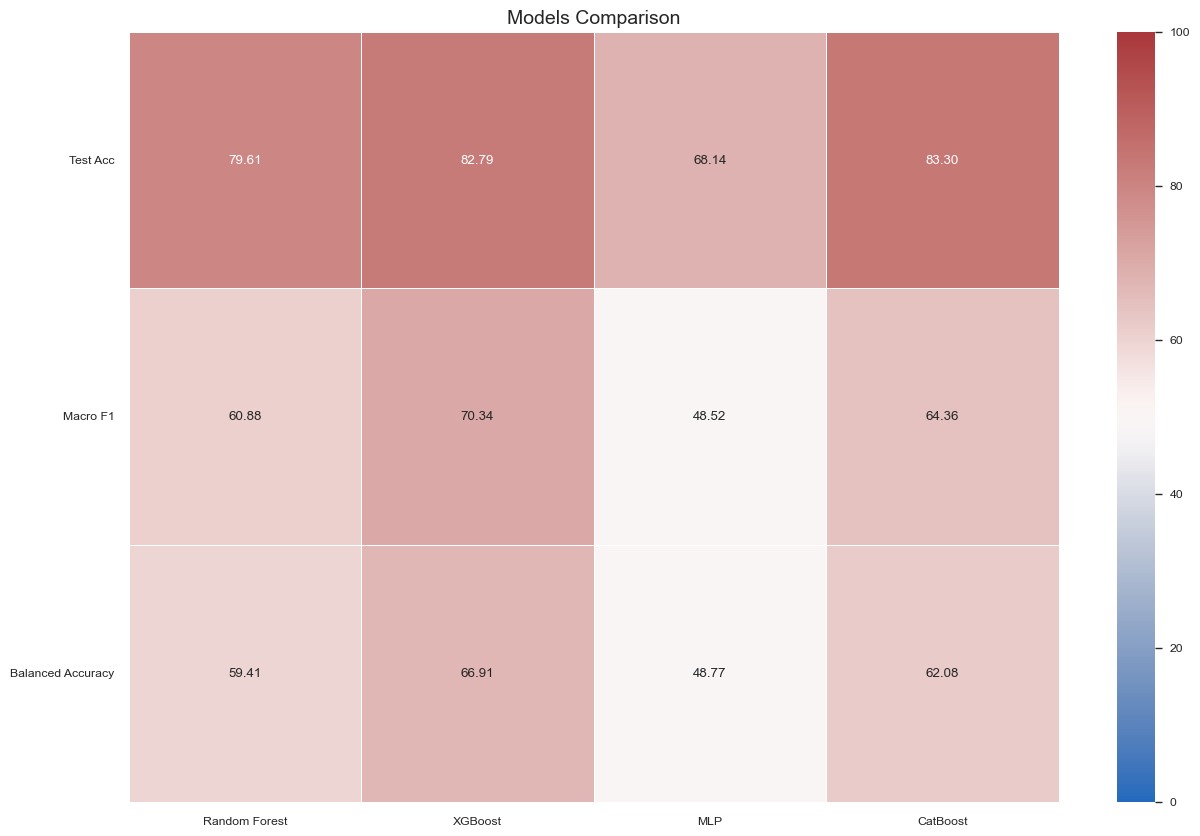

In [17]:
result_df = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(
    result_df.astype(float) * 100,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    vmax=100,
    vmin=0,
    linewidths=0.5,
)
# plt.title("Accuracy (%)", fontsize=14)
plt.title("Models Comparison", fontsize=14)
plt.yticks(rotation=0)

Text(-2.3, 6, 'Predicted')

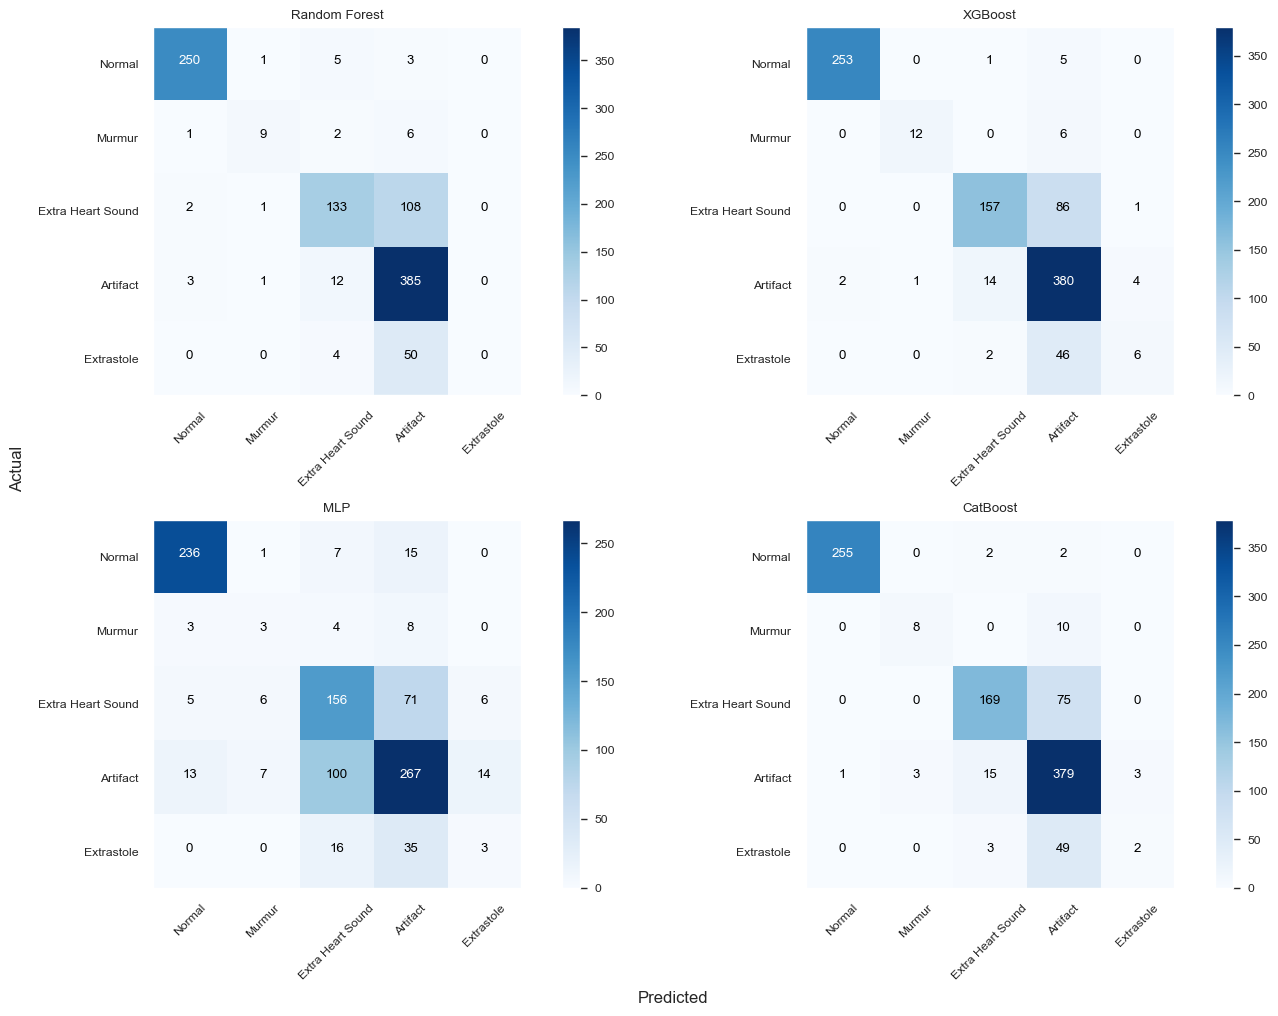

In [18]:
# function to plot a specific confusion matrix
import itertools


def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    # remove grid
    plt.grid(False)


# load the confusion matrix
cm_dict = np.load(MODELS_RESULTS + CM_NAME, allow_pickle=True).item()

# plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

for i, (model_name, cm) in enumerate(cm_dict.items()):
    plt.subplot(2, 2, i + 1)
    plot_confusion_matrix(
        cm,
        classes=["Normal", "Murmur", "Extra Heart Sound", "Artifact", "Extrastole"],
        title=model_name,
    )
# set xlabels for the entire figure with plt.text
plt.text(-11.3, -1.2, "Actual", fontsize=12, va="center", rotation=90)
plt.text(-2.3, 6, "Predicted", fontsize=12, ha="center", va="center")